In [24]:
# from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
from itertools import islice
from datetime import datetime
import seaborn as sns
from operator import add
import pandas as pd
import numpy as np
import json
from geopy.distance import geodesic as GD
# sc = SparkContext()

In [2]:
data_2019 = pd.read_csv("Divvy_Trips_2019_full.csv")

/tmp/ipykernel_15264/2296370465.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2019 = pd.read_csv("Divvy_Trips_2019_full.csv")


In [3]:
data_2019.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,21742443,2019-01-01 00:04:37,2019-01-01 00:11:07,2167,390.0,199,Wabash Ave & Grand Ave,84,Milwaukee Ave & Grand Ave,Subscriber,Male,1989.0
1,21742444,2019-01-01 00:08:13,2019-01-01 00:15:34,4386,441.0,44,State St & Randolph St,624,Dearborn St & Van Buren St (*),Subscriber,Female,1990.0
2,21742445,2019-01-01 00:13:23,2019-01-01 00:27:12,1524,829.0,15,Racine Ave & 18th St,644,Western Ave & Fillmore St (*),Subscriber,Female,1994.0
3,21742446,2019-01-01 00:13:45,2019-01-01 00:43:28,252,"1,783.0",123,California Ave & Milwaukee Ave,176,Clark St & Elm St,Subscriber,Male,1993.0
4,21742447,2019-01-01 00:14:52,2019-01-01 00:20:56,1170,364.0,173,Mies van der Rohe Way & Chicago Ave,35,Streeter Dr & Grand Ave,Subscriber,Male,1994.0


In [7]:
len(data_2019['bikeid'].unique())
#количество велосипедов

6259

In [ ]:
data_2020 = pd.read_csv("Divvy_Trips_2020_full.csv")

/tmp/ipykernel_58260/3578714930.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2020 = pd.read_csv("Divvy_Trips_2020_full.csv")


In [ ]:
data_2020.head()

In [10]:
def get(line):
    r = line.split(',')
    trip_id = r[0]
    start_time = r[1]
    end_time = r[2]
    bikeid = r[3]
    tripduration = r[4]
    from_station = r[5]
    from_station_name = r[6]
    to_station_id = r[7]
    to_station_name = r[8]
    usertype = r[9]
    gender = r[10]
    birthyear = r[11]
    return trip_id, start_time, end_time, bikeid, tripduration, from_station_name, to_station_name
def get2(line):
    r = line[0]
    l = line
def get3(line):
    p = line.split(',')
    return p[4], (p[8], p[9])
def result_table(line):
    main_part = line[0][0]
    from_place = line[0][1]
    to_place = line[1]
    return f"{main_part[0]},{main_part[1]},{main_part[2]},{main_part[3]},{main_part[4]},{main_part[5]},{main_part[6]},{from_place[0]},{from_place[1]},{to_place[0]},{to_place[1]}"

In [12]:
data = sc.textFile("Divvy_Trips_2019_full.csv").map(get).keyBy(lambda x: x[5])

station_info = sc.textFile("Divvy_Trips_2020_full.csv").map(get3) \
.reduceByKey(lambda a, b: a)

data = data.join(station_info).map(lambda x: x[1]).keyBy(lambda x: x[0][6]).join(station_info) \
.map(lambda x: x[1]).map(result_table).coalesce(1).saveAsTextFile("table_with_geo")

In [3]:
df = pd.read_csv("table_with_geo/part-00000")

In [4]:
df.columns = ['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration', 'from_station_name', 'to_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng']

In [5]:
df = df[df["start_time"] < df['end_time']]
df = df.dropna(subset=['start_time', 'end_time'])

In [6]:
df["distance"] = df.apply(
    lambda x: float(str(GD(
        (x["start_lat"], x["start_lng"]), (x["end_lat"], x["start_lng"])))[:-3]
    ) +
    float(str(GD(
        (x["end_lat"], x["start_lng"]), (x["end_lat"], x["end_lng"])))[:-3]
    )
    ,
    axis=1,
)

In [7]:
df.columns = ['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration', 'from_station_name', 'to_station_name', 'start_lat', 'start_lng', 'end_lat','end_lng', 'distance, km']

In [8]:
df["speed"] = df.apply(
    lambda x: x['distance, km'] / (x['tripduration'] / 3600),
    axis=1,
)

In [9]:
df.head(100)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_name,to_station_name,start_lat,start_lng,end_lat,end_lng,"distance, km",speed
0,13381389,3/8/2017 17:28:08,3/8/2017 17:40:32,1193,744.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,12.907388
1,13319510,2/27/2017 17:32:05,2/27/2017 17:44:16,199,731.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,13.136932
2,13289642,2/22/2017 17:29:51,2/22/2017 17:41:50,5430,719.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,13.356185
3,13284692,2/22/2017 12:17:16,2/22/2017 12:32:05,2735,889.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,10.802134
4,13228790,2/17/2017 17:23:00,2/17/2017 17:33:56,3845,656.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,14.638867
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,14220321,5/29/2017 15:48:45,5/29/2017 16:15:05,4356,1580.0,Broadway & Belmont Ave,Lakefront Trail & Bryn Mawr Ave,41.9401,-87.6455,41.984,-87.6523,5.439611,12.394051
96,14186539,5/27/2017 16:51:54,5/27/2017 17:21:26,5141,1772.0,Broadway & Belmont Ave,Lakefront Trail & Bryn Mawr Ave,41.9401,-87.6455,41.984,-87.6523,5.439611,11.051129
97,14186523,5/27/2017 16:51:22,5/27/2017 17:21:35,865,1813.0,Broadway & Belmont Ave,Lakefront Trail & Bryn Mawr Ave,41.9401,-87.6455,41.984,-87.6523,5.439611,10.801213
98,13998479,5/14/2017 11:30:56,5/14/2017 11:54:24,866,1408.0,Broadway & Belmont Ave,Lakefront Trail & Bryn Mawr Ave,41.9401,-87.6455,41.984,-87.6523,5.439611,13.908097


In [10]:
df.dtypes

trip_id                int64
start_time            object
end_time              object
bikeid                 int64
tripduration         float64
from_station_name     object
to_station_name       object
start_lat            float64
start_lng            float64
end_lat              float64
end_lng              float64
distance, km         float64
speed                float64
dtype: object

In [74]:
#количество велосипедов, использованных в 2019 году
len(df['bikeid'].unique())

6258

In [53]:
#среднее расстояние пройденное за одну поездку в км
df['distance, km'].mean()

2.4112437849275064

In [78]:
#медианное расстояние пройденное за одну поездку в км
df['distance, km'].median()

1.9424417488931685

In [79]:
#медианное расстояние в км на велосипедах за год
df.groupby(['bikeid']).sum()['distance, km'].median(numeric_only=True)

C:\Users\Ульяна\AppData\Local\Temp\ipykernel_1780\3041403492.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['bikeid']).sum()['distance, km'].median(numeric_only=True)


1473.9689452874693

In [17]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_name,to_station_name,start_lat,start_lng,end_lat,end_lng,"distance, km",speed
0,13381389,3/8/2017 17:28:08,3/8/2017 17:40:32,1193,744.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,12.907388
1,13319510,2/27/2017 17:32:05,2/27/2017 17:44:16,199,731.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,13.136932
2,13289642,2/22/2017 17:29:51,2/22/2017 17:41:50,5430,719.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,13.356185
3,13284692,2/22/2017 12:17:16,2/22/2017 12:32:05,2735,889.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,10.802134
4,13228790,2/17/2017 17:23:00,2/17/2017 17:33:56,3845,656.0,Sheridan Rd & Montrose Ave,Lakefront Trail & Bryn Mawr Ave,41.9617,-87.6546,41.984,-87.6523,2.667527,14.638867


In [18]:
#медианная скорость в км.ч
df['speed'].median()

11.933039650219657

C:\Users\Ульяна\AppData\Local\Temp\ipykernel_1780\557023359.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['speed'], hist=True, kde=False,


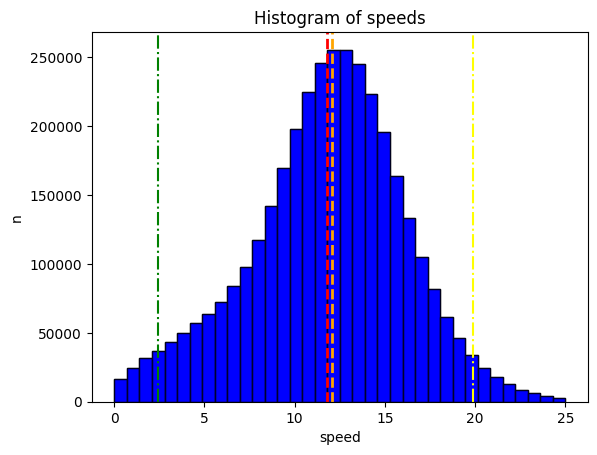

In [70]:
# matplotlib histogram
plt.hist(df['speed'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(df['speed'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of speeds')
plt.xlabel('speed')
plt.ylabel('n')
mean = np.mean(df['speed'])
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
median = np.median(df['speed'])
plt.axvline(median, color='orange', linestyle='dashed', linewidth=2)
q1 = np.quantile(df['speed'], 0.025)
q3 = np.quantile(df['speed'], 0.975)
plt.axvline(q1, color='green', linestyle='-.')
plt.axvline(q3, color='yellow', linestyle='-.')

In [71]:
#средняя скоровь в км.ч
df['speed'].median()

12.089774607237507

In [69]:
df = df[df['speed'] <= 25]
df = df[df['distance, km'] != 0]
df = df[df['tripduration'] > 60]

In [72]:
len(df)

3549833

In [73]:
len(copy_df)

3673727

In [46]:
#copy_df = df[:]

In [77]:
#тормозные колодки
#Кассета и её система
#цепь
#вилка
#рулевая колонка
len(df['bikeid'].unique()) * (880 + 400 + 400 + 2200 + 1800 + 600) / 81.99

479329.6743505306